# Imports

# Kaggle Imports

In [1]:
import cv2
import os
import math
import random #rng
from PIL import Image #handle images
from matplotlib.patches import Polygon #draw polygons on plots
import re #regex
from subprocess import check_output #run commands
from keras.models import Sequential
from keras.layers import Input, Convolution2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils


Using TensorFlow backend.


# DM Project Imports

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import collections
from keras import regularizers
from keras.optimizers import rmsprop
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

# Data Is Fetched

In [3]:
class ImageData:
    def __init__(self, img_name, boxes):
        self.img_name = img_name
        self.boxes = boxes

def parse_directory(path):
    """Parse a directory containing negative images to a list of ImageData"""
    img_names = os.walk(path)
    #img_names = check_output(["ls", path]).decode("utf8").split("\n")
    data = []
    
    img_names = os.walk(path)
    
    
    for img_tuple in img_names:
        
        for img_name in img_tuple[2]:
            match = re.search(r'G\d+\.JPG', img_name)
            if(match):
                data.append(ImageData(match.group(), []))
    print(len(data))
            
    return data
    
def parse_txt_file(filepath, filename):
    """Parse the txt file containing image relative paths, name, and boxes data to a list of ImageData"""
    file = open(filepath + filename)
    items = file.read().strip().split("\n")
    item_regex = r'(^[\w\s]+\\(?:[\w\s]+\\)*G\d+\.bmp)\s+(\d+)\s+((?:\d+\s+\d+\s+\d+\s+\d+\s*)+)'
    
    def parse_item(item):
        match = re.match(item_regex, item)
        
        img_path = match.group(1).replace('.bmp', '.JPG') #txt says bmp but images are actually jpg
        img_name = re.search(r'G\d+\.JPG', img_path).group()
        num_boxes = int(match.group(2))
        values = re.findall(r'\d+', match.group(3))
        boxes = [tuple([ int(values[i*4+j]) for j in range(0,4)]) for i in range(0,num_boxes)]
        
        return ImageData(img_name, boxes)
    
    return [parse_item(item) for item in items]


class ImageColleciton:
    def __init__(self, data, path):
        self.data = data
        self.path = path
        
src_path = "G:/FYP/Untitled Folder/input"
dataset2_path = src_path + "/Dataset 2 (Complex)/"
dataset1_path = src_path + "/Dataset 1 (Simplex)/"

img_collections = {
    "dataset2_complex": {
        "train": {
            "positive": ImageColleciton(
                parse_txt_file(dataset2_path, "complexTrainFullSizeAllPotholes.txt"),
                dataset2_path + "Train data/Positive data/"
            ),
            "negative": ImageColleciton(
                parse_directory(dataset2_path + "Train data/Negative data/"),
                dataset2_path + "Train data/Negative data/"
            )
        },
        "test": ImageColleciton( #test images have only positive data
            parse_txt_file(dataset2_path, "complexTestFullSizeAllPotholes.txt"),
            dataset2_path + "Test data/"
        ),
    },
    "dataset1_simplex": {
        "train": {
            "positive": ImageColleciton(
                parse_txt_file(dataset1_path, "simpleTrainFullPhotosSortedFullAnnotations.txt"),
                dataset1_path + "Train data/Positive data/"
            ),
            "negative": ImageColleciton(
                parse_directory(dataset1_path + "Train data/Negative data/"),
                dataset1_path + "Train data/Negative data/"
            )
        },
        "test": ImageColleciton( #test images have only positive data
            parse_txt_file(dataset1_path, "simpleTestFullSizeAllPotholesSortedFullAnnotation.txt"),
            dataset1_path + "Test data/"
        ),
    }
}

print("done " + str(random.random()))

6192
3399
done 0.12387079612563501


# Train and Test Data Are Split

In [4]:
IMG_W = 3680
IMG_H = 2760
CHANNELS = 3
CROP_X = (0,0) #take CROP_X[0] from the left and CROP_X[1] from the right
CROP_Y = (1000,800) #take CROP_Y[0] from the top and CROP_Y[1] from the bottom
cropped_img_w = IMG_W - CROP_X[0] - CROP_X[1]
cropped_img_h = IMG_H - CROP_Y[0] - CROP_Y[1]
pos_col = img_collections["dataset1_simplex"]["train"]["positive"]
neg_col = img_collections["dataset1_simplex"]["train"]["negative"]

def ImageCollection_to_full_paths(img_col):
    return [img_col.path + img.img_name for img in img_col.data]

def read_n_crop_img_from_path(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    cropped_img = image[CROP_Y[0]:IMG_H - CROP_Y[1], CROP_X[0]:IMG_W - CROP_X[1]]
    return cropped_img

def train_val_test_split(img_paths, labels, val_split, test_split):
    count_samples = len(labels)
    count_val = math.floor(count_samples * val_split)
    count_test = math.floor(count_samples * test_split)
    count_train = count_samples - count_val - count_val
    labels = list(labels)
    
    img_paths_val = []
    labels_val = []
    indexes_val = list(np.random.choice(count_samples, count_val, replace=False))
    indexes_val.sort(reverse=True)
    
    for i in indexes_val:
        img_paths_val.append(img_paths.pop(i))
        labels_val.append(labels.pop(i))
        
        img_paths_test = []
        
    count_samples = len(labels)
    labels_test = []
    indexes_test = list(np.random.choice(count_samples, count_test, replace=False))
    indexes_test.sort(reverse=True)
    
    for i in indexes_test:
        img_paths_test.append(img_paths.pop(i))
        labels_test.append(labels.pop(i))
        
    return img_paths, labels, img_paths_val, labels_val, img_paths_test, labels_test

def imageGenerator(img_full_paths, labels, batch_size):
    rand_indexes = []
    
    while True: 
        X_batch = np.ndarray((batch_size, cropped_img_h, cropped_img_w, CHANNELS), dtype=np.uint8)
        y_batch = np.ndarray((batch_size,))
        
        while(len(rand_indexes) < batch_size):
            more_indexes = list(range(0,len(img_full_paths)))
            random.shuffle(more_indexes)
            rand_indexes = more_indexes + rand_indexes
        
        for j in range(batch_size):
            i = rand_indexes.pop()
            X_batch[j] = read_n_crop_img_from_path(img_full_paths[i])
            y_batch[j] = labels[i]
            
        yield (X_batch, y_batch)


img_full_paths = ImageCollection_to_full_paths(pos_col) + ImageCollection_to_full_paths(neg_col)
labels = np.concatenate((np.ones(len(pos_col.data)), np.zeros(len(neg_col.data))))

img_paths_train, labels_train, img_paths_val, labels_val, img_paths_test, labels_test = train_val_test_split(img_full_paths, labels, 0.1, 0.01)    

print(len(img_paths_train))
print(len(img_paths_val))
print(len(img_paths_test))
print(labels_test)

4504
506
50
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


# Neural Network 

In [5]:
model = Sequential([
    
    Conv2D(8, (7, 7), padding='same', input_shape=(cropped_img_h, cropped_img_w, CHANNELS), activation='relu'),
    Conv2D(8, (7, 7), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),

    Conv2D(16, (5, 5), padding='same', activation='relu'),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.4),
    
    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(1),
    Activation('sigmoid')
])
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 960, 3680, 8)      1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 960, 3680, 8)      3144      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 480, 1840, 8)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 480, 1840, 8)      1608      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 120, 460, 8)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 460, 16)      3216      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 460, 16)     

# Train the Neural network

In [13]:
model.fit_generator(
    generator = imageGenerator(img_paths_train, labels_train, 6), 
    steps_per_epoch = 200, 
    validation_data = imageGenerator(img_paths_val, labels_val, 6), 
    validation_steps = 200,
    epochs = 8, 
    verbose = 1, 
    shuffle = True
)

Epoch 1/8
200/200 [==============================] - 439s 2s/step - loss: 0.6952 - accuracy: 0.7633 - val_loss: 0.5069 - val_accuracy: 0.6567
Epoch 2/8
200/200 [==============================] - 433s 2s/step - loss: 0.4783 - accuracy: 0.8242 - val_loss: 0.6198 - val_accuracy: 0.8467
Epoch 3/8
200/200 [==============================] - 432s 2s/step - loss: 0.4042 - accuracy: 0.8458 - val_loss: 0.4231 - val_accuracy: 0.8550
Epoch 4/8
200/200 [==============================] - 432s 2s/step - loss: 0.4118 - accuracy: 0.8383 - val_loss: 0.4035 - val_accuracy: 0.8558
Epoch 5/8
200/200 [==============================] - 433s 2s/step - loss: 0.4348 - accuracy: 0.8358 - val_loss: 0.7067 - val_accuracy: 0.8442
Epoch 6/8
200/200 [==============================] - 433s 2s/step - loss: 0.4481 - accuracy: 0.8308 - val_loss: 1.3678 - val_accuracy: 0.8333
Epoch 7/8
200/200 [==============================] - 432s 2s/step - loss: 0.4878 - accuracy: 0.8225 - val_loss: 0.5756 - val_accuracy: 0.8342
Epoch 

# Save Model

In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Load Saved Model

In [15]:
from keras.models import model_from_json
import image


# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [16]:
test_generator = imageGenerator(img_paths_test, labels_test, 12)

In [17]:
X_test, y_test = next(test_generator)

# Test Image

In [18]:
def prep_imgs_for_plt(imgs):
    return [np.flip(img, 2) for img in imgs]
    
def avg_img(img_list):
    return np.array(img_list).mean(axis=0, dtype=np.uint32)

def show_img(img, text="", prep=True):
    if(prep):
        img = prep_imgs_for_plt([img])[0]
    fig, ax = plt.subplots(1, figsize=(25,25))
    ax.set_title(text)
    ax.imshow(img)

def apply_threshold(threshold, data):
    return [0 if item < threshold else 1 for item in data]

def display_prediction(X, y, index):
    image = X[index]
    print (image.shape)
    label = y[index]
    pred = loaded_model.predict(np.expand_dims(image, axis=0))
    print (np.expand_dims(image, axis=0).shape)
    show_img(image, "label: {}, prediction: {}".format(label, pred))
    
    
def my_display_prediction(image):
    pred = loaded_model.predict(np.expand_dims(image, axis=0))
    #show_img(image, "label: {}, prediction: {}".format(1, pred))
    return pred
    
    
#show_img(avg_img(X_train), "Average train data image")
#rand_i = random.randrange(0, len(X_train))
#show_img(X_train[rand_i], f'Random image: {rand_i}')

In [21]:
s, e = 0,12
print(apply_threshold(0.5, loaded_model.predict(X_test[s:e], verbose=1)))
print(y_test[s:e])

12/12 [==============================] - 1s 93ms/step
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]


(960, 3680, 3)
(1, 960, 3680, 3)


(12, 960, 3680, 3)

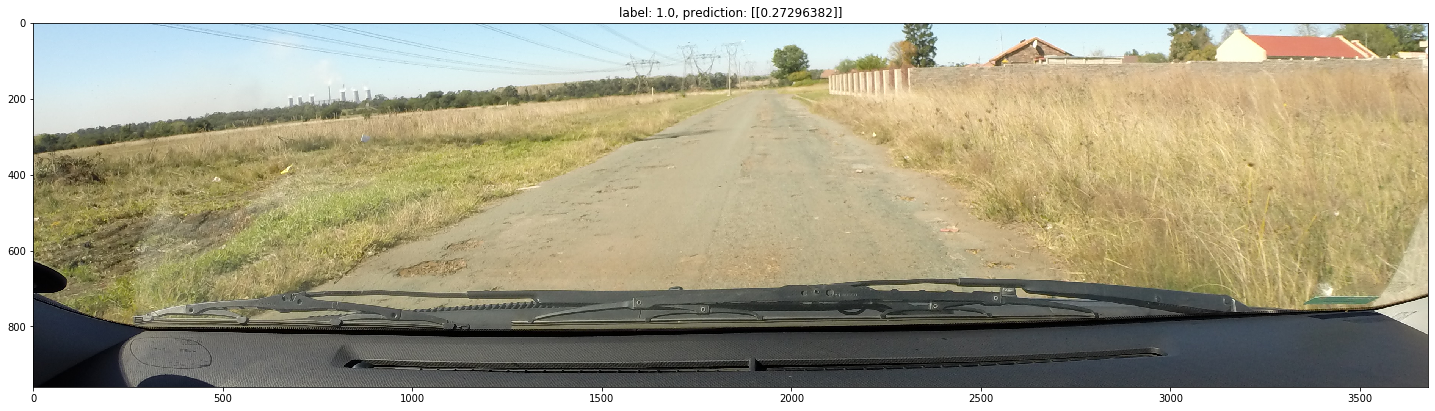

In [24]:
X_test, y_test = next(test_generator)

display_prediction(X_test, y_test, 1)
X_test.shape

In [25]:
# open an image file (.bmp,.jpg,.png,.gif) you have in the working folder
imageFile = "My Test/96.jpg"
im1 = Image.open(imageFile)
# adjust width and height to your needs
width = 3680
height = 960
# use one of these filter options to resize the image
#im2 = im1.resize((width, height), Image.NEAREST)      # use nearest neighbour
#im3 = im1.resize((width, height), Image.BILINEAR)     # linear interpolation in a 2x2 environment
im4 = im1.resize((width, height), Image.BICUBIC)      # cubic spline interpolation in a 4x4 environment
#im5 = im1.resize((width, height), Image.ANTIALIAS)    # best down-sizing filter
ext = ".jpg"
show_img(im1)
#show_img(im2)
#show_img(im3)
show_img(im4)
#show_img(im5)

FileNotFoundError: [Errno 2] No such file or directory: 'My Test/96.jpg'

In [ ]:
img_names = os.walk('C:/Users/Dragon/FYP/Untitled Folder/My test/')
    
    
imageFile = "My Test/3.jpg"
im1 = Image.open(imageFile)

width = 3680
height = 960

im4 = im1.resize((width, height), Image.BICUBIC)

im4 = im1.resize((width, height), Image.BICUBIC)      # cubic spline interpolation in a 4x4 environment

X_test = im4.convert('RGB')

my_display_prediction(X_test)


In [26]:
cap = cv2.VideoCapture('C:\\Users\\Dragon\\Videos\\New folder\\DASH+CAM+2016+01+29+%2842+Miles+of+Potholes%29_Trim.mp4')

width = 3680
height = 960
i = 0

fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
fps = int(fps)

frame_count = 0

while(cap.isOpened()): 
      
    # Capture frame-by-frame 
    ret, frame = cap.read() 
    if ret == True: 
        
        resize_frame = cv2.resize(frame, (width, height))
        
        # Display the resulting frame 
        #cv2.imshow('Frame',  resize_frame) 
        
        if (frame_count % fps == 0):
            if (my_display_prediction(resize_frame)>=0.35):
                name="C:/Users/Dragon/FYP/Untitled Folder/pothole/img" + str(i) + ".jpg"
                
                cv2.imwrite(name, frame, [cv2.IMWRITE_JPEG_QUALITY, 65])
                i += 1
                
                cv2.imshow('Frame',  frame) 
                cv2.waitKey(1500)
        
        
        # Press Q on keyboard to  exit 
        #if cv2.waitKey(25) & 0xFF == ord('q'):
        if 0xFF == ord('q'):
              break
        
    # Break the loop 
    else:  
        break

    frame_count += 1
        
        
cap.release()
cv2.destroyAllWindows()

In [ ]:

cap = cv2.VideoCapture('C:\\Users\\Dragon\\Videos\\New folder\\VID_20190924_145333.mp4')

fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"

fps